<a href="https://colab.research.google.com/github/pierce3215/finances/blob/main/LSTM_Technical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import math
import pandas_datareader as web
import yfinance as yf

https://github.com/tejaslinge/Stock-Price-Prediction-using-LSTM-and-Technical-Indicators/blob/main/Price%20Prediction%20using%20LSTM%20and%20TA.ipynb

In [6]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [26]:
ticker = input("ENTER THE STOCK WHOSE PREDICTION YOU WANT : ")
data = yf.download(ticker, start='2000-01-01' , end='2023-10-06')
print(data.tail())

ENTER THE STOCK WHOSE PREDICTION YOU WANT : SPY
[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-09-29  431.670013  431.850006  425.910004  427.480011  427.480011   
2023-10-02  426.619995  428.600006  424.459991  427.309998  427.309998   
2023-10-03  425.059998  427.369995  420.179993  421.589996  421.589996   
2023-10-04  422.070007  425.429993  420.559998  424.660004  424.660004   
2023-10-05  424.359985  425.369995  421.170013  424.500000  424.500000   

               Volume  
Date                   
2023-09-29  115078500  
2023-10-02   83798600  
2023-10-03  103760600  
2023-10-04   87453000  
2023-10-05   70103300  


In [27]:
data = data[['Adj Close']]
data.columns = ['Price']
data.head()

,Price
Date,
2000-01-03,94.262543
2000-01-04,90.576317
2000-01-05,90.738342
2000-01-06,89.280045
2000-01-07,94.465118


In [28]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 5978 number of days in the dataset.


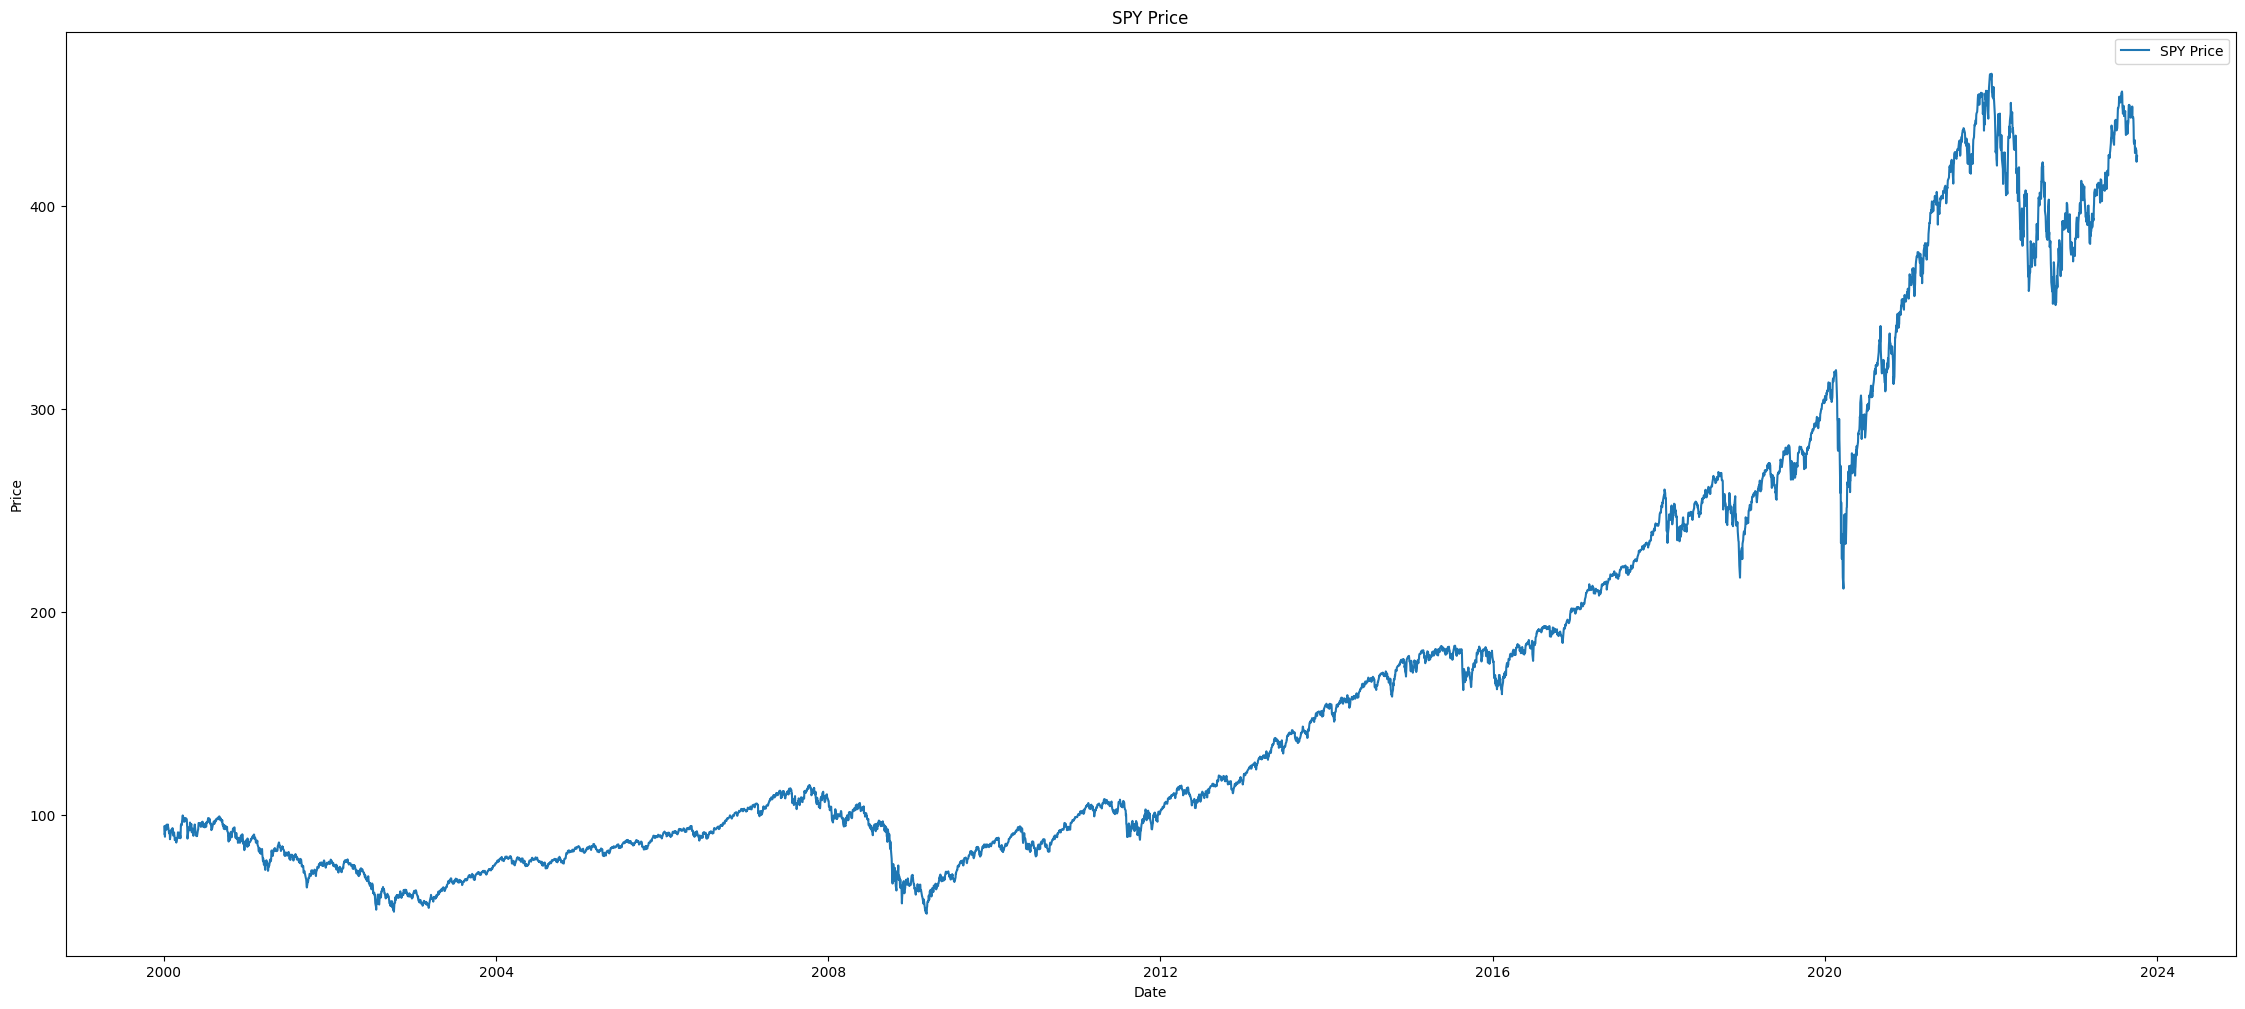

In [29]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(df.index, data['Price'], label='SPY Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SPY Price')
plt.legend()
plt.show()

In [30]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Price'].rolling(window=21).mean()

    # Create MACD
    dataset['26ema'] = dataset['Price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Price'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Price'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['Price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [34]:
df = get_technical_indicators(data)

In [35]:
df = df.dropna()
df.head()

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2000-02-01,91.345978,90.712321,92.472488,92.083850,91.555399,-0.528452,2.087108,96.646703,88.298273,90.895777,90.345978,4.503646
2000-02-02,91.426956,90.778864,92.337460,92.024224,91.535124,-0.489099,2.057016,96.451492,88.223427,91.249896,90.426956,4.504542
2000-02-03,92.804260,90.894596,92.443552,92.093865,91.734655,-0.359210,2.018740,96.481032,88.406072,92.286139,91.804260,4.519659
2000-02-04,92.419472,91.059526,92.523606,92.122500,91.841959,-0.280541,1.980713,96.485032,88.562180,92.375027,91.419472,4.515458
2000-02-07,92.277664,91.256279,92.666350,92.135959,91.910036,-0.225923,1.838156,96.342663,88.990037,92.310119,91.277664,4.513906


In [36]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

<Figure size 1600x1000 with 0 Axes>

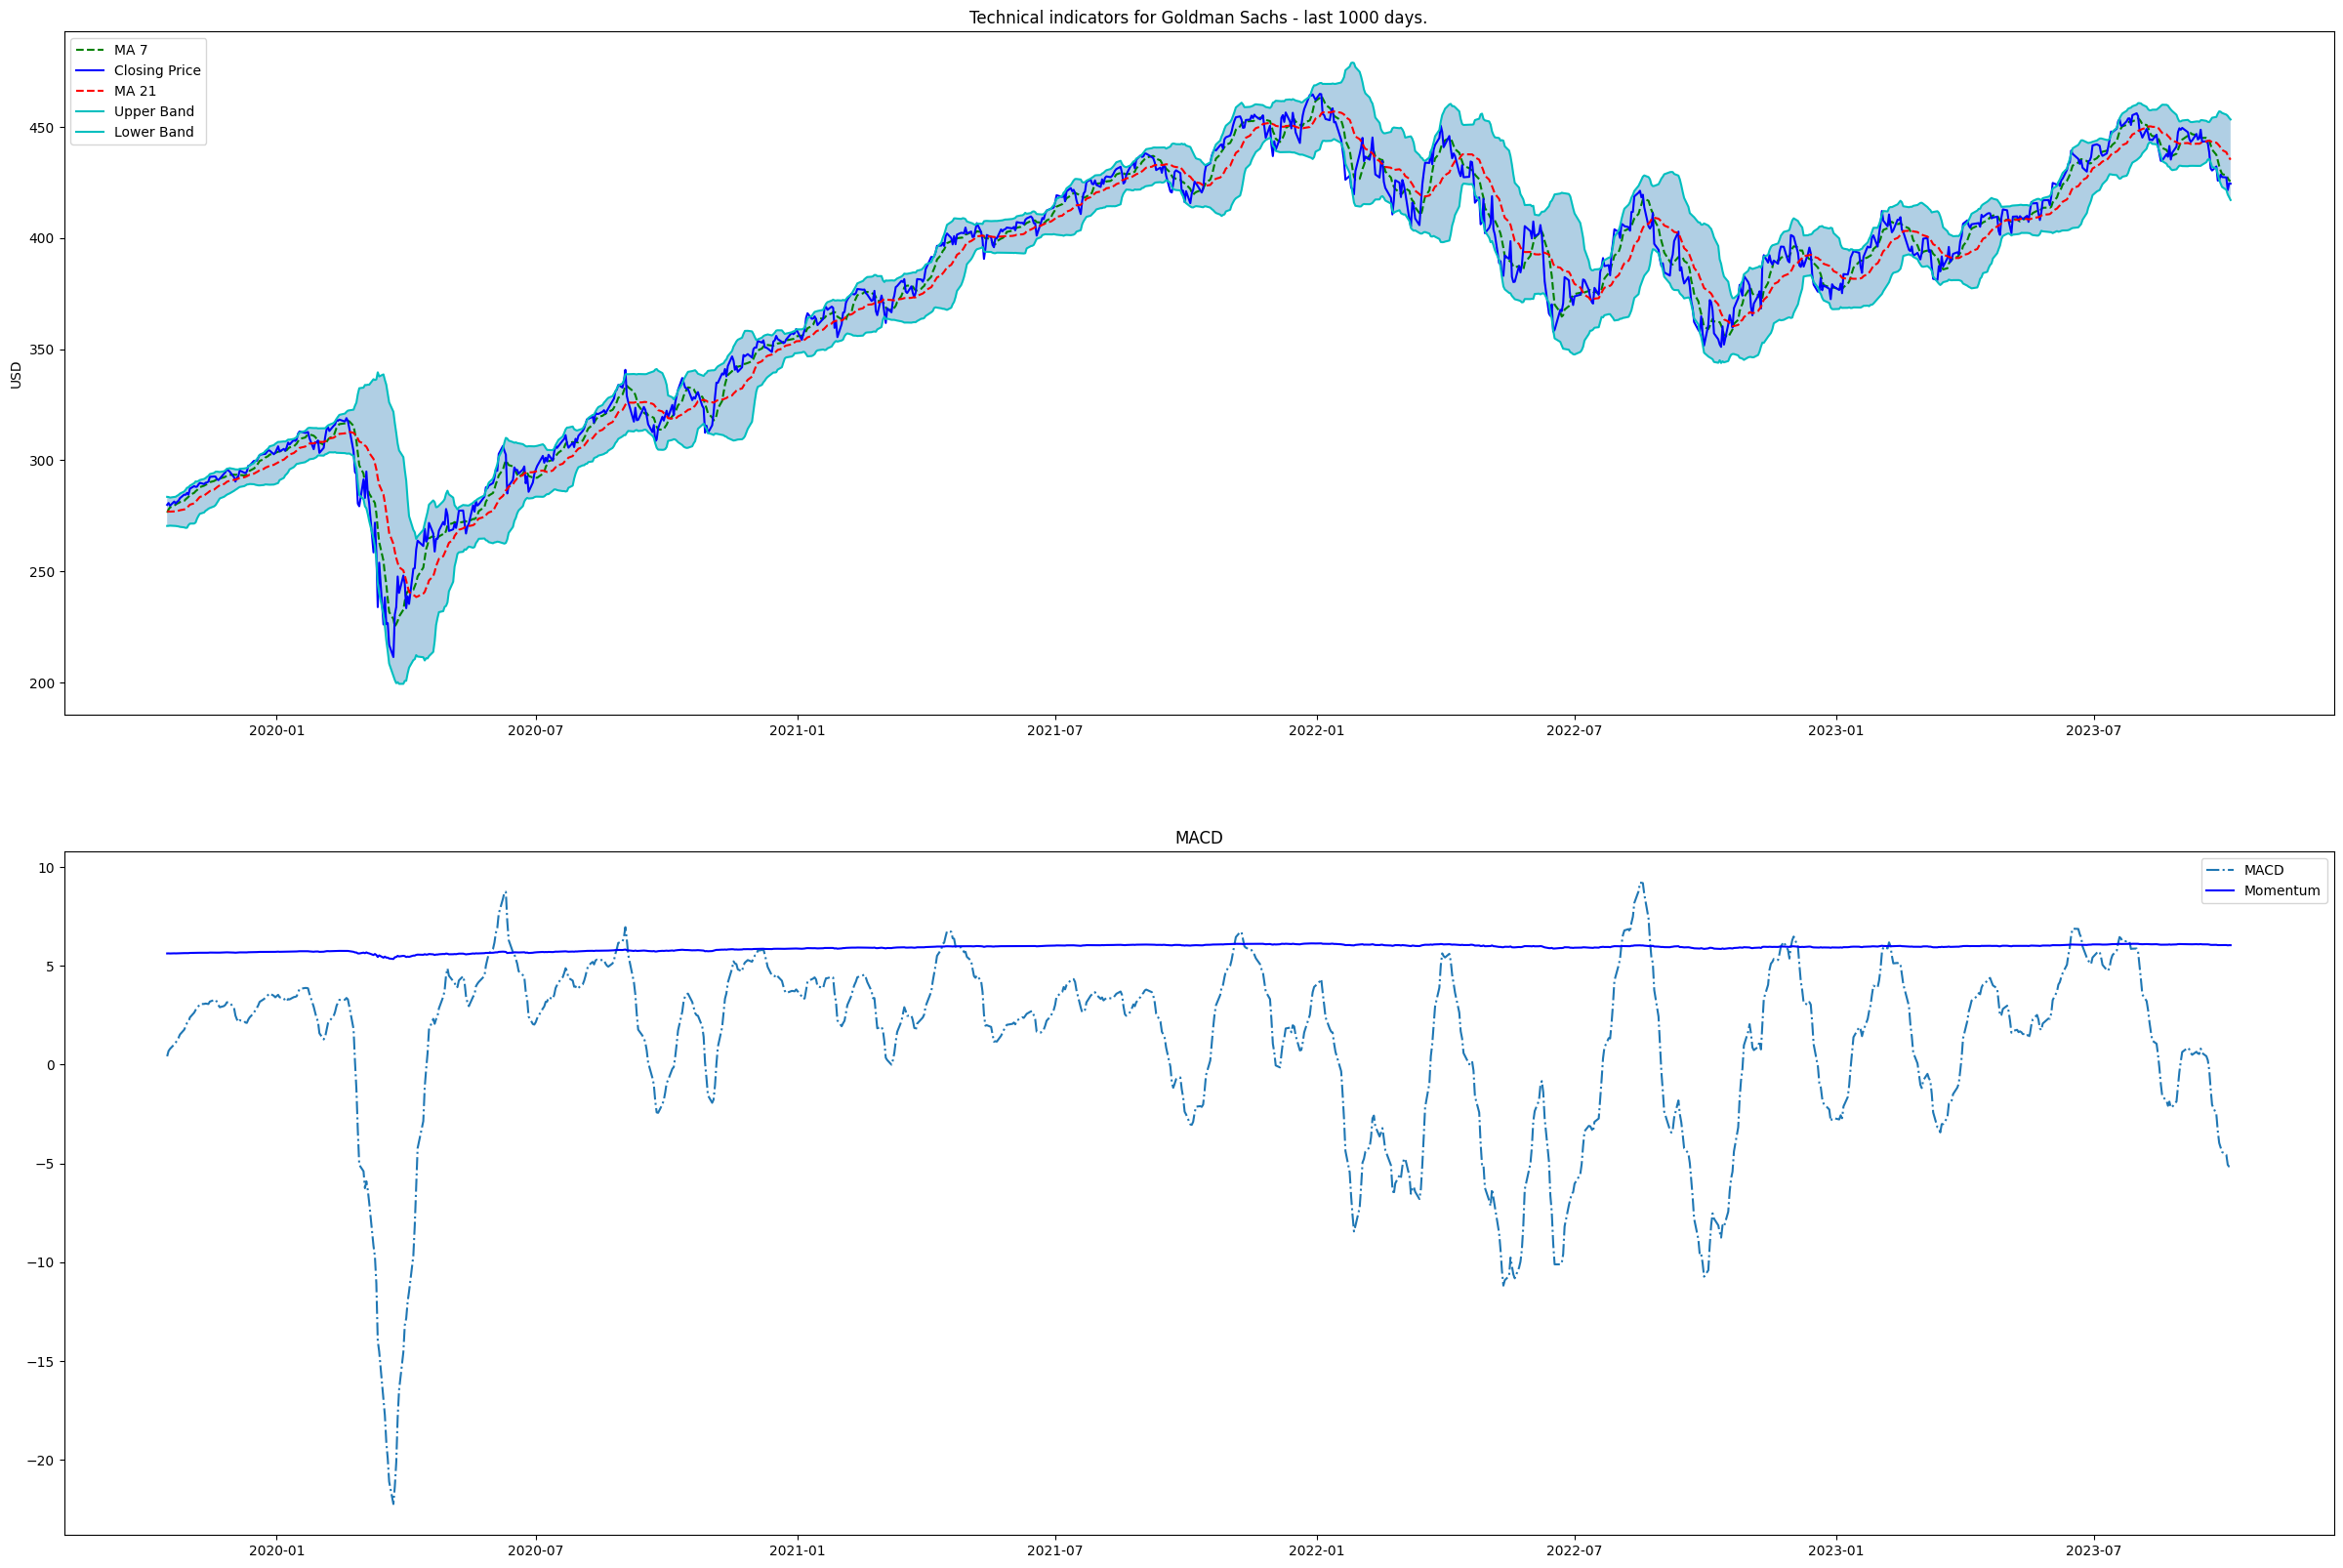

In [37]:
plot_technical_indicators(df, 1000)

Text(0.5, 1.0, 'Params')

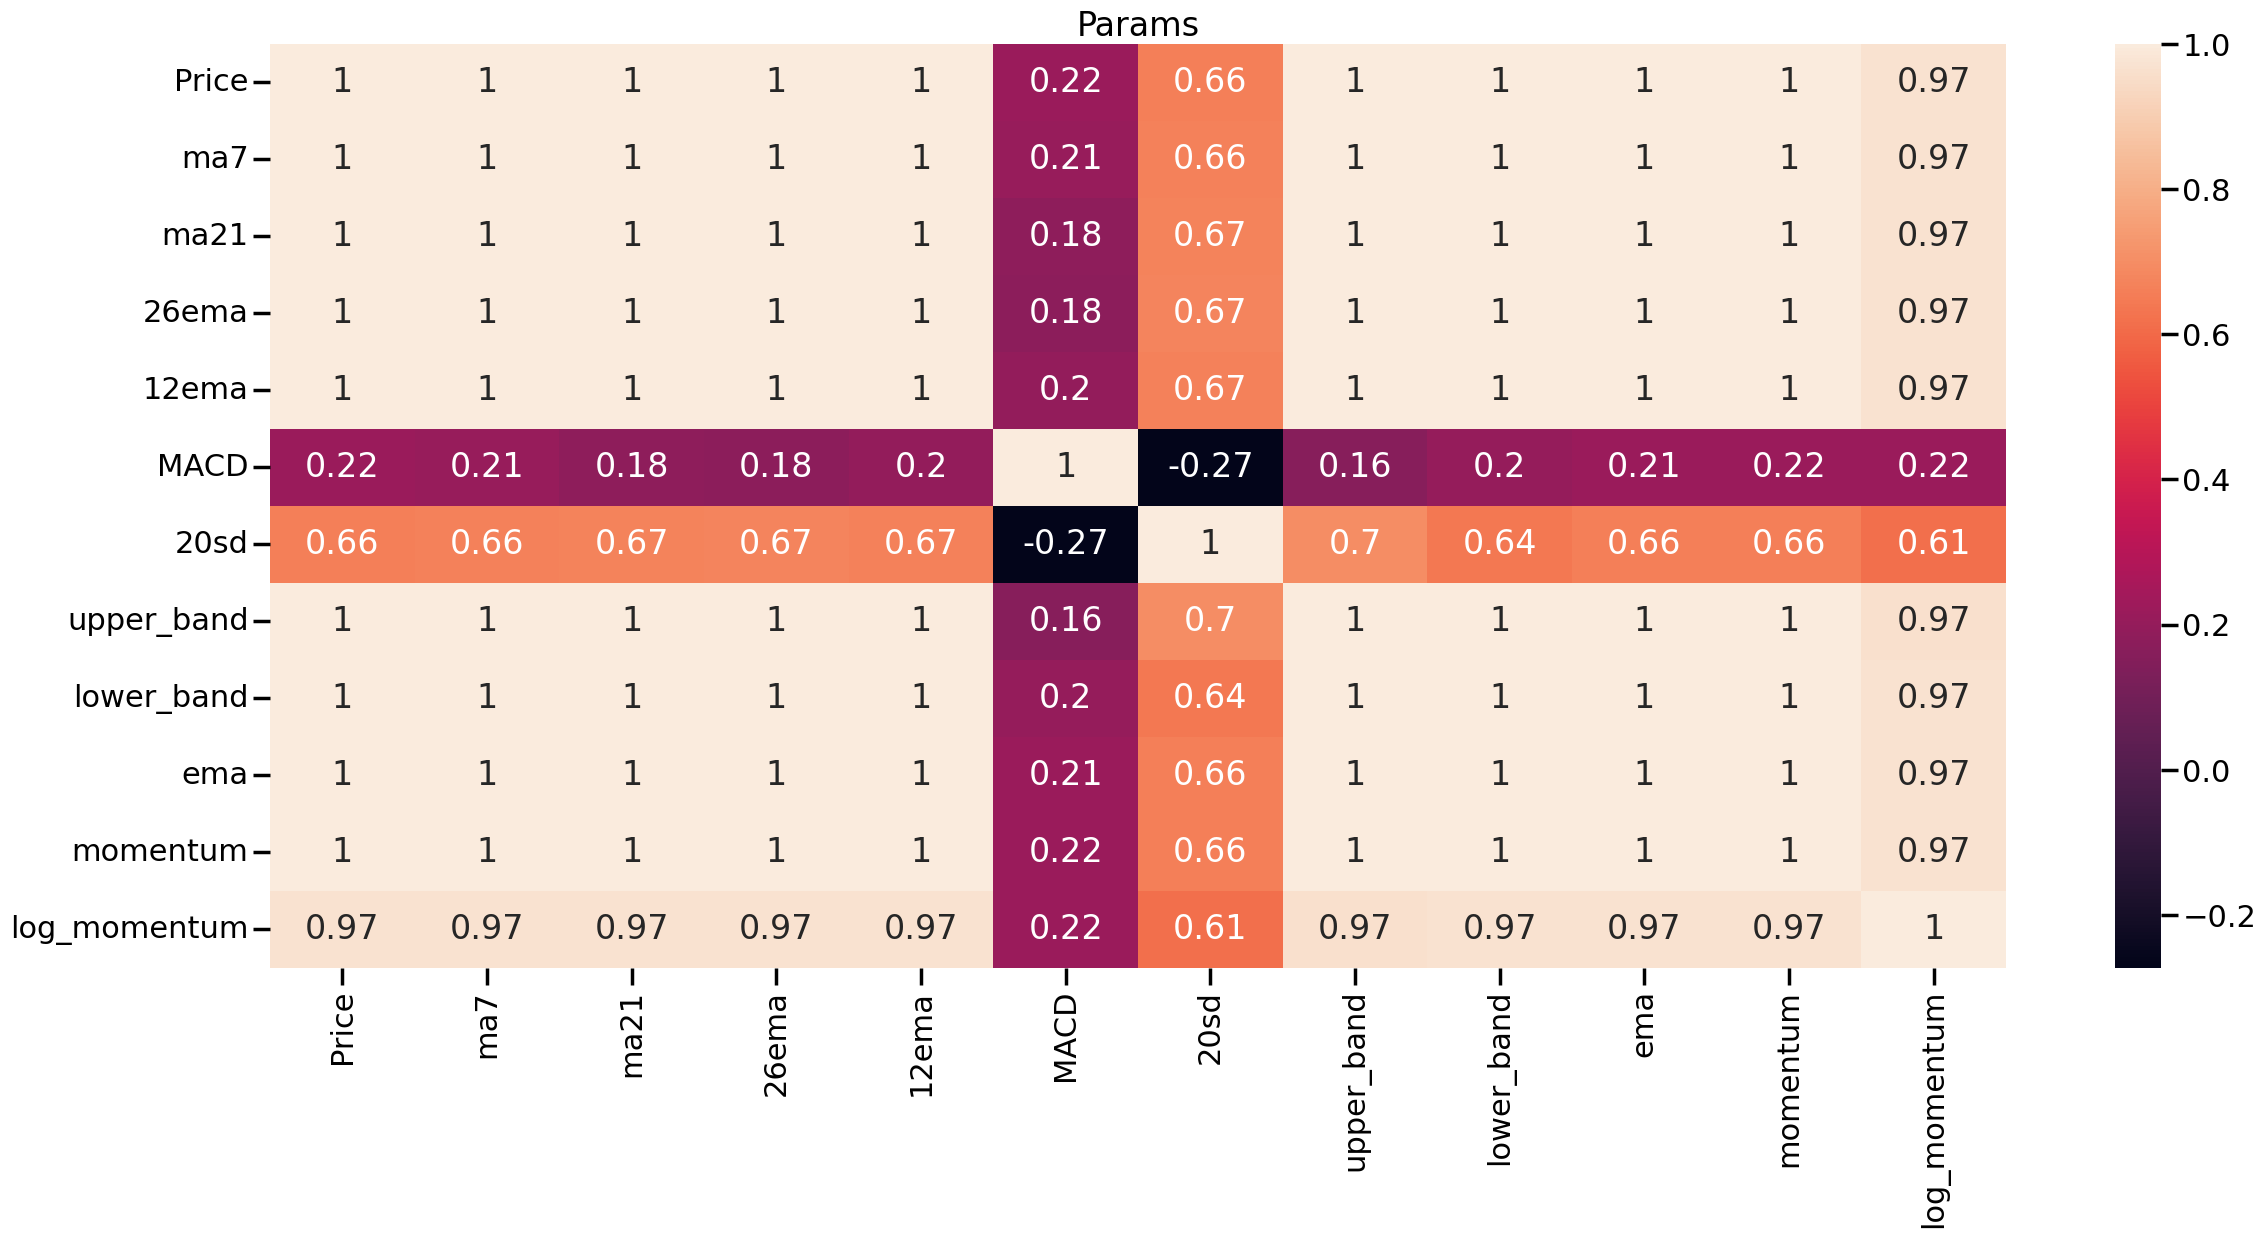

In [38]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(df.corr(), annot = True).set_title('Params')

In [39]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 5958 samples, and 12 features.


In [40]:
df.columns

Index(['Price', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema', 'momentum', 'log_momentum'],
      dtype='object')

In [41]:
df

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2000-02-01,91.345978,90.712321,92.472488,92.083850,91.555399,-0.528452,2.087108,96.646703,88.298273,90.895777,90.345978,4.503646
2000-02-02,91.426956,90.778864,92.337460,92.024224,91.535124,-0.489099,2.057016,96.451492,88.223427,91.249896,90.426956,4.504542
2000-02-03,92.804260,90.894596,92.443552,92.093865,91.734655,-0.359210,2.018740,96.481032,88.406072,92.286139,91.804260,4.519659
2000-02-04,92.419472,91.059526,92.523606,92.122500,91.841959,-0.280541,1.980713,96.485032,88.562180,92.375027,91.419472,4.515458
2000-02-07,92.277664,91.256279,92.666350,92.135959,91.910036,-0.225923,1.838156,96.342663,88.990037,92.310119,91.277664,4.513906
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,427.480011,428.852862,439.678941,437.538269,433.118627,-4.419642,8.320077,456.319094,423.038787,427.622208,426.480011,6.055565
2023-10-02,427.309998,428.270002,438.657176,436.780619,432.224992,-4.555627,8.464474,455.586123,421.728228,427.414068,426.309998,6.055167
2023-10-03,421.589996,427.008571,437.323171,435.655388,430.588839,-5.066549,8.851635,455.026441,419.619901,423.531353,420.589996,6.041658


In [42]:
data_training = df[df.index < '2019-01-31'].copy()
data_training

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2000-02-01,91.345978,90.712321,92.472488,92.083850,91.555399,-0.528452,2.087108,96.646703,88.298273,90.895777,90.345978,4.503646
2000-02-02,91.426956,90.778864,92.337460,92.024224,91.535124,-0.489099,2.057016,96.451492,88.223427,91.249896,90.426956,4.504542
2000-02-03,92.804260,90.894596,92.443552,92.093865,91.734655,-0.359210,2.018740,96.481032,88.406072,92.286139,91.804260,4.519659
2000-02-04,92.419472,91.059526,92.523606,92.122500,91.841959,-0.280541,1.980713,96.485032,88.562180,92.375027,91.419472,4.515458
2000-02-07,92.277664,91.256279,92.666350,92.135959,91.910036,-0.225923,1.838156,96.342663,88.990037,92.310119,91.277664,4.513906
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-24,243.863541,243.297767,236.083929,239.552212,241.130050,1.577838,7.433424,250.950776,221.217082,243.837797,242.863541,5.492500
2019-01-25,245.926926,244.015533,237.469239,240.024413,241.868031,1.843618,6.289652,250.048543,224.889935,245.230550,244.926926,5.500960
2019-01-28,244.057877,244.383015,238.243851,240.323188,242.204930,1.881742,6.034634,250.313118,226.174584,244.448768,243.057877,5.493300


In [43]:
data_testing = df[df.index >= '2019-01-31'].copy()
data_testing

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2019-01-31,249.766983,245.525112,240.675196,241.737918,244.238090,2.500172,5.695899,252.066993,229.283398,248.639910,248.766983,5.516517
2019-02-01,249.887299,246.404160,241.551153,242.341576,245.107199,2.765624,5.627110,252.805373,230.296932,249.471502,248.887299,5.517000
2019-02-04,251.645370,247.515850,242.773876,243.030746,246.113072,3.082326,4.800811,252.375497,233.172254,250.920748,250.645370,5.524039
2019-02-05,252.700119,248.483449,243.686398,243.746996,247.126464,3.379468,4.778504,253.243407,234.129390,252.106995,251.700119,5.528238
2019-02-06,252.367081,249.670478,244.495379,244.385520,247.932712,3.547192,4.739576,253.974531,235.016227,252.280386,251.367081,5.526914
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,427.480011,428.852862,439.678941,437.538269,433.118627,-4.419642,8.320077,456.319094,423.038787,427.622208,426.480011,6.055565
2023-10-02,427.309998,428.270002,438.657176,436.780619,432.224992,-4.555627,8.464474,455.586123,421.728228,427.414068,426.309998,6.055167
2023-10-03,421.589996,427.008571,437.323171,435.655388,430.588839,-5.066549,8.851635,455.026441,419.619901,423.531353,420.589996,6.041658


In [44]:
scalar = MinMaxScaler()

data_training_scaled = scalar.fit_transform(data_training)
print(data_training_scaled.shape)
data_training_scaled

(4779, 12)


array([[0.18374638, 0.17617144, 0.17361077, ..., 0.18103047, 0.18374638,
        0.34950048],
       [0.18411875, 0.17648111, 0.17297012, ..., 0.18266404, 0.18411875,
        0.35003673],
       [0.19045207, 0.17701969, 0.17347348, ..., 0.18744428, 0.19045207,
        0.35908449],
       ...,
       [0.88596882, 0.89130356, 0.86523369, ..., 0.88937793, 0.88596882,
        0.94185114],
       [0.88447935, 0.89158037, 0.86844059, ..., 0.88717964, 0.88447935,
        0.94105295],
       [0.90222238, 0.89226935, 0.87258617, ..., 0.89831338, 0.90222238,
        0.95049273]])

In [45]:
X_train = []
y_train = []

In [47]:
for i in range(60, data_training.shape[0]):
    X_train.append(data_training_scaled[i-60: i])
    y_train.append(data_training_scaled[i, 0])

In [48]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((9438, 60, 12), (9438,))

In [49]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 12)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

In [50]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            12600     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [51]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
regressor.fit(X_train, y_train, epochs=50, batch_size = 64)

In [ ]:
past_60 = data_training.tail(60)

dt = past_60.append(data_testing, ignore_index = True)
dt

In [ ]:
inputs = scalar.fit_transform(dt)
print(inputs.shape)
inputs

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
y_pred

In [ ]:
scale = 1/scalar.scale_[0]

In [ ]:
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Bank Nifty Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bank Nifty Price')
plt.title('Bank Nifty Price Prediction-After 10 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Bank Nifty Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bank Nifty Price')
plt.title('Bank Nifty Price Prediction-After 25 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Bank Nifty Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bank Nifty Price')
plt.title('Bank Nifty Price Prediction-After 50 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()